In [17]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [20]:
outfit_data = pd.read_csv("../dataset/outfit_data.csv")
product_data = pd.read_csv("../dataset/product_data_cleaned.csv")

In [21]:
outfit_data.head()

,cod_outfit,cod_modelo_color
0,1,51000622-02
1,1,43067759-01
2,1,53060518-02
3,1,53030594-08
4,1,43077762-01


In [22]:
merged = product_data.merge(outfit_data, on="cod_modelo_color")
merged = merged.sort_values(by=['cod_outfit'])

In [23]:
merged.head()

,Unnamed: 0,cod_modelo_color,cod_color_code,des_agrup_color_eng,des_fabric,des_product_category,des_product_type,des_filename,des_product_family,cod_outfit
31366,6843,43077762-01,1.000000,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Necklace,2019_43077762_01.jpg,Jewellery,1
7176,1506,43075794-OR,4.400709,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Bracelet,2019_43075794_OR.jpg,Jewellery,1
381,78,53030594-08,8.000000,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Handbag,2019_53030594_08.jpg,Bags,1
17616,3786,51000622-02,2.000000,WHITE,K-CIRCULAR,Tops,Top,2019_51000622_02.jpg,Tops,1
12890,2766,43063724-OR,4.400709,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Earrings,2019_43063724_OR.jpg,Jewellery,1


In [25]:
# show unique des_product_type from merged where des_product_aggregated_family == Accesories

merged[merged['des_product_family'] == 'Footwear']['des_product_type'].unique()

array(['Sandals', 'Trainers', 'Shoes', 'Ankle Boots', 'Boots', 'Clogs',
       'Slippers'], dtype=object)

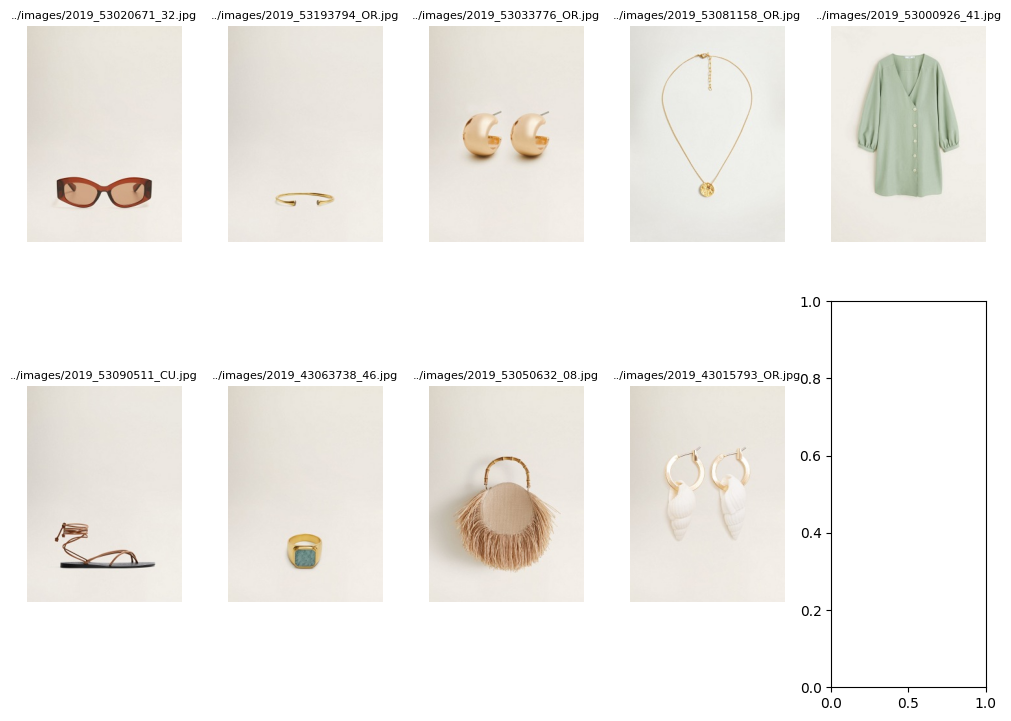

In [26]:
def show_outfit(cod_outfit): 
    outfit = merged[merged['cod_outfit'] == cod_outfit]
    outfit = outfit['des_filename'].values.tolist()
    outfit = ["../images/" + path.split('/')[-1] for path in outfit]
        
    num_images = len(outfit)
    num_rows = 2
    num_cols = (num_images + 1) // 2  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for i, image_path in enumerate(outfit):
        row_idx = i // num_cols
        col_idx = i % num_cols
        img = mpimg.imread(image_path)
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis('off')  
        axes[row_idx, col_idx].set_title(image_path, fontsize=8)

    plt.tight_layout()
    plt.show()

show_outfit(1000)

In [27]:
class Outfit:
    def __init__(self, rows=None):
        """
        Initializes an Outfit object with the given rows.

        Args:

        rows: a list of rows representing the outfit components.
        """
        if rows is None:
            rows = []

        self.top = 0
        self.bottom = 0
        self.accessories = {}
        self.complete_set = 0
        self.footwear = 0
        self.outerwear = 0
        self.rows = rows

        # print(rows)
        for row in rows:
            print(row["des_product_family"])
            # print(type(row))
            # print(row.des_product_family)
            if row["des_product_family"].values[0] == "Footwear":
                self.footwear += 1
            elif row["des_product_category"].values[0] == "Top":
                self.top += 1
            elif row["des_product_category"].values[0] == "Bottom":
                self.bottom += 1
            elif row["des_product_category"].values[0] == "Dresses, jumpsuits and Complete set":
                self.complete_set += 1
            elif row["des_product_category"].values[0] == "Outerwear":
                self.outerwear += 1
            elif row["des_product_category"].values[0] == "Accesories, Swim and Intimate":
                self.accessories[row["des_product_family"]] += 1

In [28]:
def outfit_valid(outfit):
    condition1 = outfit.top == 1 and outfit.bottom == 1 and outfit.footwear == 1 and outfit.complete_set == 0
    condition2 = outfit.complete_set == 1 and outfit.footwear == 1 and outfit.top == 0 and  outfit.bottom == 0
    condition3 = outfit.outerwear <= 1
    condition4 = len(outfit.accessories) <= 4

    for key, value in outfit.accessories.items():
        if value > 1:
            return False

    return (condition1 or condition2) and condition3 and condition4

def parcial_outfit_valid(outfit):
    cond1 = outfit.top <= 1 and outfit.complete_set == 0
    cond2 = outfit.bottom <= 1 and outfit.complete_set == 0
    cond3 = outfit.complete_set <= 1 and outfit.top == 0 and outfit.bottom == 0
    cond4 = outfit.footwear <= 1
    cond5 = outfit.outerwear <= 1
    cond6 = len(outfit.accessories) <= 4

    for key, value in outfit.accessories.items():
        if value > 1:
            return False

    return (cond1 or cond2 or cond3) and cond4 and cond5 and cond6

In [34]:
from pytorch_metric_learning.distances import LpDistance

def get_embedding(model, x):
    return model(torch.tensor(x.values,dtype=torch.float32,requires_grad=True))
import	pickle
def get_recommendation(model, x, item_id, product_data, embeddings=None):
    if embeddings is None:  
        embeddings = get_embedding(model, x)
    
    Lp = LpDistance(normalize_embeddings=False)

    Lp_sim = Lp(embeddings, embeddings[item_id].unsqueeze(0))
    index_dict = pickle.load(open("../dataset/dict_index_modelo.pickle", "rb"))
    modelo = index_dict[item_id]
    
    
    idx = torch.argsort(Lp_sim.squeeze())

    topk=list(zip(idx.tolist(), Lp_sim[idx].tolist()))
    
    topk.sort(key=lambda x: x[1],reverse=True)
    print(len(topk))
    return topk,modelo
def complete_outfit(product_data,modelo)
    # print(product_data[product_data['cod_modelo_color'] == modelo])
    
    current_outfit = Outfit([product_data[product_data['cod_modelo_color'] == modelo]])
    while not outfit_valid(current_outfit): 
        # print(topk)
        for modelo in topk: 
            id = modelo[0]
            mod = index_dict[id]
            new_element = [product_data[product_data['cod_modelo_color'] == mod]]
            if parcial_outfit_valid(Outfit(current_outfit.rows.append(new_element))): 
                current_outfit = Outfit(current_outfit.rows.append(new_element))
                break           
        
    return current_outfit

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MyNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x
x = pd.read_csv('../dataset/X.csv')

input_size = x.shape[1]-1
hidden_size1 = 64
hidden_size2 = 32
output_size = 20
model = MyNN(input_size, hidden_size1, hidden_size2, output_size)
model.load_state_dict(torch.load("../dataset/model.pth"))

<All keys matched successfully>

In [36]:
out = get_recommendation(model, x.drop(columns=['cod_modelo_color']), 1000, product_data)

8985
1228    Footwear
Name: des_product_family, dtype: object


In [27]:
product_data = pd.read_csv('../dataset\product_data_cleaned.csv')
id = product_data.iloc[8000]["cod_modelo_color"]
row_number = product_data[product_data["cod_modelo_color"] == id].index[0]
model.load_state_dict(torch.load("../model.pth"))# x=torch.tensor(x.values,dtype=torch.float32,requires_grad=True)
top100 = get_recommendation(model, x, row_number,k=1000)

[(5537, [2.523185003155959e-06]),
 (1161, [2.523185003155959e-06]),
 (7166, [2.431401981084491e-06]),
 (5803, [2.431401981084491e-06]),
 (4477, [2.431401981084491e-06]),
 (1310, [2.431401981084491e-06]),
 (6011, [2.431401981084491e-06]),
 (2620, [2.336015541004599e-06]),
 (1346, [2.336015541004599e-06]),
 (734, [2.336015541004599e-06]),
 (5672, [2.336015541004599e-06]),
 (4177, [2.336015541004599e-06]),
 (2946, [2.336015541004599e-06]),
 (8066, [2.336015541004599e-06]),
 (8558, [2.336015541004599e-06]),
 (8437, [2.236564569102484e-06]),
 (3408, [2.236564569102484e-06]),
 (6147, [2.236564569102484e-06]),
 (5940, [2.236564569102484e-06]),
 (1102, [2.236564569102484e-06]),
 (8116, [2.236564569102484e-06]),
 (3192, [2.236564569102484e-06]),
 (5282, [2.236564569102484e-06]),
 (5993, [2.236564569102484e-06]),
 (7074, [2.236564569102484e-06]),
 (8526, [2.236564569102484e-06]),
 (3176, [2.236564569102484e-06]),
 (7681, [2.236564569102484e-06]),
 (5488, [2.236564569102484e-06]),
 (160, [2.23656

In [ ]:
# select a random id from 0 to len(product_data)
id = random.randint(0, len(product_data))
random_id = product_data.iloc[id]["cod_modelo_color"]
top100 = get_recommendation(model, x, id, k=1000)

top100[:10]

In [ ]:
# get x columns not containing "weight" in name
imp=x.columns[x.columns.str.contains("weight") == False]
x[imp].iloc[1234]

In [ ]:
categories = product_data["des_product_category"].unique().tolist()

# create a dictionry with the categoreis as keys and 0 values for each category
category_dict = {}
for category in categories:
    category_dict[category] = []
    
# fill the dictionary with the top 100 recommendations for each category
for modelo in top100:
    category = product_data.iloc[modelo[0]]["des_product_category"]
    category_dict[category].append(modelo[0])

display_images([get_image_path(product_data.iloc[id]["cod_modelo_color"], product_data)])

for category in category_dict:
    x = product_data.iloc[category_dict[category][0]]["cod_modelo_color"]
    display_images([get_image_path(x, product_data)])

In [ ]:
display_images([get_image_path(dict_index_modelo[top[0]], product_data) for top in top100]) 


display_images([get_image_path(random_id, product_data)])

In [ ]:
import matplotlib.pyplot as plt
def display_images(paths):
    fig=plt.figure(figsize=(10, 20))
    columns = 4
    rows = 5
    for i in range(1, min(columns*rows +1, len(paths)+1)):
        img = plt.imread(paths[i-1][9:])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

def get_image_path(cod_modelo_color, outfit_data):
    return outfit_data[outfit_data['cod_modelo_color'] == cod_modelo_color]['des_filename'].values[0]
  
# load from datasets dict_index_modelo pickle 
import pickle
with open('dataset/dict_index_modelo.pickle', 'rb') as handle:
    dict_index_modelo = pickle.load(handle)

In [ ]:
# display id image
display_images([get_image_path(id, product_data)])

In [ ]:
display_images([get_image_path(dict_index_modelo[top[0]], product_data) for top in top100])